# HW: Transformers
In this assignment you will be implementing a transformer model and using it to predict the next character.
To submit this assignment, upload this notebook to Gradescope containing your implementations and responses to the questions below.

## Building the Transformer
One of the goals of this assignment is for you to build your own transformer model in PyTorch. Specifically, this means creating a neural network with the following structure, where $x$ is the input to the network of $t$ tokens:  

\begin{align}
    y = &\ \textrm{embedding}(x) + \textrm{pos\_enc}(1:t) \\
    h^1 = &\ \textrm{transformer\_layer}(y) \\
    h^2 = &\ \textrm{transformer\_layer}(h^1)\\
    \vdots \\
    h^{k} = &\ \textrm{transformer\_layer}(h^{k-1}) \\
    \hat x= &\ \textrm{linear\_layer}(\textrm{layer\_norm}(h^k)),
\end{align}
where $\hat x$ represents a prediction of the next token for each of the input token, i.e., $\hat x_{i}$ is a prediction of $x_{i+1}$, $\textrm{embedding}$ is an embedding layer which maps a token to a vector, $\textrm{pos\_enc}$ is provides the positional encoding of each token (this must have the same dimensions as the embedding layer output), $\textrm{transformer\_layer}$ is group of operations defined below that contain self-attention and a MLP and will be repeated $k$ times. The last linear layer maps the embedding space back to the space of tokens to compute probabilities over the next token.

The transformer will be trained using the negative log-likelihood of the next token prediction. You should use the PyTorch class CrossEntropy to compute the loss.

The operations of the transformer are described further below.

### Embedding and Positional Encoding
The embedding layer is a mapping from a one-hot encoding of each token to a vector embedding. This layer is just a linear operation of $xW$, where $x \in [0,1]^{d}$ is a one hot vector representing one of $d$ possible tokens and $W \in \mathbb{R}^{d \times n}$ maps that token to an $n$ dimensional embedding space. For efficiency $x$ never has to be explicitly represented by a one-hot vector and instead is just an integer. The layer returns the $i^\text{th}$ row of the matrix if $x$ represents the $i^\text{th}$ possible token.

The positional encoding layer returns the positional encoding for each position of the sequence, i.e., if the sequence has length $L$, then the positional encoder returns a matrix of dimension $L \times n$, where $n$ is the same dimension as the embedding layer. The positional encoding for the $t$ position is
\begin{equation}
    p(t) = \begin{bmatrix}
    \sin(w_1 t) \\
    \cos(w_1 t) \\
    \sin(w_2 t) \\
    \cos(w_2 t) \\
    \vdots \\
    \sin(w_{n/2} t) \\
    \cos(w_{n/2} t) \\
    \end{bmatrix},
\end{equation}
where $w_i = \frac{1}{N^{2i/n}}$ is the frequency of the sine and cosine waves and $N$ is a hyperparameter the controls the how low the frequencies go. Smaller frequencies means representing long periods of time. For numerical stability reasons the computation of $w_i$ is broken up as follows
\begin{equation}
    w_i = e^{2i \frac{-\ln N}{n}}.
\end{equation}

Note that these position encoding do not have to be computed every time the network is run. Instead they can compute precomputed for some maximum sequence length, then only the $L$ encodings that are needed for the input sequence are used.

Also notice that the positional encoding is added to the embedding layer representation for the character. Since this embedding layer will be optimized, it will be able to learn a feature representation that works with the positional encoding.



### Transformer Layer

Using PyTorch implement your own transformer layer. This layer should will be similar to what we discussed in class and contain the following sequence of operations for the input $x$
\begin{align}
    y = &\  x + \textrm{self\_attention}(\textrm{layer\_norm}(x)) \\
    z = &\ y + \textrm{dropout}(\textrm{MLP}(\textrm{layer\_norm}(y))),
\end{align}
where \textrm{self\_attention} is multi-head self-attention, \textrm{layer\_norm} normalizes the activations of the hidden units, \textrm{MLP} is a MLP perception with one hidden layer and ReLU activation function, and \textrm{dropout} is a dropout layer that randomly sets layer outputs to zero with probability $p=0.2$. Note that all of these operations preserve the width of the network, i.e., the dimensions of $x$, $y$, and $z$ are the same.
%
For each of the components above you may use the built in pytorch classes and functions, but you must write your own TransformerLayer class, which brings these all together.
%
It is important to read the pytorch documentation for each operation to make sure you have the correct dimensions and inputs for each operation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import os

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=512, N=1_000.0):
        """
        Initialize the PositionalEncoding object.
        This will precompute the positional encoding for all possible sequences of length max_len.
        At runtime only the encoding for the input sequence length will be used.

        Parameters:
        embed_size: int
            The number of features in the input
        max_len: int
            The maximum length of the input sequence. This should be the maximum length of the input sequence you will ever use. If you have a an initial prompt length of 32 and want to generate 1000 characters, then max_len should be 1032.
        N: float
            A constant used in the positional encoding to control the scale of the frequencies.
            The slowest frequency will have period of N^((embed_size-2)/embed_size) * 2 * np.pi.
            This period is a little shorter than N * 2 * np.pi. N controls the longest positional encoding that can be identified.
            Any sequence longer than this will have the same positional encoding as a shorter sequence.
            So N/(2 * pi) should be longer than the longest sequence you will use.
        """
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size
        self.max_len = max_len
        pe = torch.zeros(max_len, embed_size)  # positional encoding
        for i in range(0,max_len):
            for j in np.arange(0,embed_size-1,2):
                w=np.exp(2*j*-(np.log(N))/embed_size)
                pe[i,j]=np.sin(w*i)
                pe[i,j+1]=np.cos(w*i)

        # TODO create the positional encoding by filling in the values for pe
        pe = pe.unsqueeze(1)  # reshape to (max_len, 1, embed_size) so that it applies to each sequence in the mini-batch
        self.register_buffer('pe', pe)  # register the positional encoding as buffer so it is saved in the model state_dict but not listed as parameters


    def forward(self, x):
        """
        Forward pass of the PositionalEncoding.

        Parameters:
        x: torch.Tensor of shape (seq_len, batch_size, d_model)
            The input features

        Returns:
        torch.Tensor of shape (seq_len, batch_size, d_model)
            The input features with positional encoding added
        """
        return x + self.pe[:x.size(0)]

class TransformerLayer(nn.Module):
    def __init__(self, embed_size, nhead, layer_width=256, activation=F.relu):
        """
        Initialize the Transformer object.

        Parameters:
        embed_size: int
            The number of features in the input
        nhead: int
            The number of heads in the multiheadattention models
        layer_width: int
            The number of features in the feedforward network
        activation: callable function
            The activation function for the hidden layer in the feedforward network

        """
        super(TransformerLayer, self).__init__()
        self.embed_size = embed_size
        self.nhead = nhead

        #First Layer Norm
        self.ln1=nn.LayerNorm(embed_size)

        #multihead attention
        #class torch.ao.nn.quantizable.MultiheadAttention(embed_dim, num_heads, dropout=0.0, bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None, batch_first=False, device=None, dtype=None)
        self.mha=nn.MultiheadAttention(embed_dim=embed_size, num_heads=nhead)

        #Second Layer Norm
        self.ln2=nn.LayerNorm(embed_size)

        #feedforward network
        # Corrected MLP dimensions to ensure input/output is embed_size and hidden is layer_width
        self.ffnl1=nn.Linear(embed_size, layer_width)
        self.activation=activation
        self.ffnl2=nn.Linear(layer_width, embed_size)
        self.ffndrop=nn.Dropout(p=0.2)

        #Third layer norm
        #self.ln2=nn.LayerNorm(embed_size)

        #Linear Layer
        #self.ll=nn.Linear(layer_width,layer_width)

        #Final dropout layer
        #self.tfdrop=nn.Dropout(p=0.5)

        # TODO create the multihead attention, layer normalization, feedforward network, and dropout layers

    def forward(self, x, attn_mask, need_attn_weights=False):
        """
        Forward pass of the Transformer.
        Parameters:
        x: torch.Tensor of shape (seq_len, batch_size, d_model)
            The input features

        attn_mask: torch.Tensor of shape (seq_len, seq_len)
            The mask to apply to the attention weights

        Returns:
        torch.Tensor of shape (seq_len, batch_size, d_model)
            The output features
        """
        #seq_len=number of batches
        #
        # TODO fill in the steps below
        # normalize input
        #LayerNorm!!!!
        xnorm = self.ln1(x)

        # Ensure attn_mask is on the same device as the input xnorm
        if attn_mask is not None:
            attn_mask = attn_mask.to(xnorm.device)

        # self attention using normalized input.
        # Note that the query, key, and value inputs are all the same here when doing self-attention with nn.MultiheadAttention. These inputs are used to generate the query, key, and value vectors and are not the keys themselves.
        # Make sure to pass in the attention mask, set is_causal=True, set need_weights=need_attn_weights, and set average_attn_weights=False
        # Removed incorrect manual linear projections for Q, K, V
        att, att_weights = self.mha.forward(xnorm, xnorm, xnorm, need_weights=need_attn_weights, attn_mask=attn_mask,average_attn_weights=False,is_causal=True)

        # add attention to original input x
        y = att+x

        # layer norm and feedforward
        z = self.ln2(y)
        z=self.ffnl1(z)
        z=self.activation(z)
        z=self.ffnl2(z)
        #z=self.ffndrop(z)

        # apply dropout to the output of the feedforward network
        #z = self.tfdrop(z)
        z=self.ffndrop(z)

        # add feedforward output to z to y to get the final output
        z = z+y

        return z, att_weights


class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_size=32, num_layers=2, nhead=8, layer_width=256, activation=F.relu, max_len=1024+32, N=1_000.0, pos_enc=True):
        """
        Initialize the Transformer object.

        Parameters:
        vocab_size: int
            The size of the vocabulary
        embed_size: int
            The number of features for the embedding layer
        num_layers: int
            The number of transformer layers
        nhead: int
            The number of heads in the multiheadattention models
        layer_width: int
            The number of features in the feedforward network
        activation: callable function
            The activation function for the hidden layer in the feedforward network
        max_len: int
            The maximum length of the input sequence. This is passed to the PositionalEncoding object.
        N: float
            Constant used in the PositionalEncoding object to specify the the slowest frequency.
        pos_enc: bool
            Flag to use positional encoding or not
        """
        super().__init__()
        self.vocab_size = vocab_size # Store vocab_size for linear_final
        self.embed_size = embed_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        if pos_enc:
            self.position = PositionalEncoding(embed_size, max_len=max_len, N=N)
        else:
            self.position = nn.Identity()  # identity function does nothing

        self.transformer_layers = nn.ModuleList()  # TODO replace with tranformer layers
        for i in range(0, num_layers):
          # def __init__(self, embed_size, nhead, layer_width=256, activation=F.relu)
            self.transformer_layers.append(TransformerLayer(embed_size=self.embed_size,nhead=nhead, layer_width=layer_width,activation=activation))

        # Moved and corrected layer norm and final linear layer to __init__
        self.ln_final = nn.LayerNorm(embed_size)
        self.linear_final = nn.Linear(embed_size, vocab_size)



    def forward(self, x, attn_mask, return_att_weights=False):
        """
        Forward pass of the Transformer.

        Parameters:
        x: torch.Tensor of shape (seq_len, batch_size)
            The input features

        mask: torch.Tensor of shape (seq_len, seq_len)
            The mask to apply to the attention weights

        return_att_weights: bool
            Whether to return the attention weights or not. If False, the function will not record the attention weights.

        Returns:
        torch.Tensor of shape (seq_len, batch_size, vocab_size)
            The output features
        """
        x = self.embedding(x)
        x = self.position(x)  # this already does the addition of positional encoding with the embedding
        att_weights = []
        for layer in self.transformer_layers:
            x, att_w = layer(x, attn_mask=attn_mask, need_attn_weights=return_att_weights)
            if return_att_weights:
                att_weights.append(att_w)

          # Normalized the output of the last transformer layer and pass it through the final linear layer
        x=self.ln_final(x)
        x=self.linear_final(x)
        if return_att_weights:
            return x, att_weights
        return x

## Language Modeling
You will be training the transformer model on a next token prediction task. Specifically we will be using the tiny Shakespeare dataset which is a collection of scripts from Shakespeare's plays. For this part of the assignment you will need to parse the entire text file and find all the unique characters, build a dictionary that maps a character to an integer representing one of the characters, and build a dictionary to reverse that mapping, i.e., map from an integer to a character. The last dictionary is used to map model outputs to generate text.

Since it is not possible to train on the whole dataset at once, you will also need to create a data sampler that will sample a mini-batch of subsequences of length $L$ from the dataset. The data sampler will also return the sequence of targets which is the same first sampled sequence, but shifted to the right by one, i.e., the input data is $x_{t:t+L}$ and the targets are $x_{t+1:t+L+1}$. For simplicity of the model we will assume all subsets are of length $L$, which means if the data set has $T$ characters in it, the last possible subsequence that can be chosen starts at position $T-L-1$.  

In [3]:
def get_batch(D, context_size, batch_size):
    """
    Get a batch of data from the dataset.

    Parameters:
    D: torch.tensor of shape (L,) and dtype torch.long (int)
        The dataset
    context_size: int
        The number of characters to use as context
    batch_size: int
        The number of sampled subsequences for the mini-batch

    Returns:
    torch.tensor of shape (context_size, batch_size)
        The input data for the model
    torch.tensor of shape (context_size, batch_size)
        The target data for the model
    """
    n = len(D)
    x = None # TODO fill in the code to get the input data
    randint=torch.randint(n-context_size, (batch_size,))
    x = torch.stack([D[i:i+context_size] for i in randint],dim=1)
    y = torch.stack([D[i+1:i+context_size+1] for i in randint],dim=1) # TODO fill in the code to get the target data
    # TODO make sure to test this function to make sure the sequences look correct.
    # If you get the wrong shape of the data or order the data incorrectly the model won't learn what you want it to and will struggle.
    # a simple way to test this is to convert the integer sequences back to text and print them out.
    assert(x.shape == (context_size, batch_size))
    assert(y.shape == (context_size, batch_size))
    return x, y

def train(Dtrain, Dval, model, optimizer, criterion, context_size, batch_size, num_epochs, vocab_size, save_freq=10, save_name="transformer"):
    """
    Train the model on the data. Save the model every save_freq epochs.

    Parameters:
    Dtrain: torch.tensor of shape (Ltrain,)
        The training data
    Dval: torch.tensor of shape (Lval,)
        The validation data
    model: nn.Module
        The model to train
    optimizer: torch.optim.Optimizer
        The optimizer to use
    criterion: callable function
        The loss function to compare the model output to the target
    context_size: int
        The number of characters to use as context
    batch_size: int
        The number of samples in each batch
    num_epochs: int
        The number of epochs to train for
    save_freq: int
        The frequency with which to save the model
    save_name: str
        The name to use when saving the model
    """
    # TODO read over this function to understand how to train the model.
    tlosses = []
    vlosses = []
    updates_per_epoch = len(Dtrain)//(batch_size*context_size)
    # prep the validation data
    even_eval = len(Dval)//(context_size+1)
    Dval = Dval[:even_eval*(context_size+1)].reshape(-1, context_size+1).T
    # create the mask for the transformer
    mask = torch.nn.Transformer.generate_square_subsequent_mask(context_size)  # create the mask for the transformer which is always the same because we sample the same length sequences
    mask = mask.to(Dtrain.device)  # move the mask to the same device as the data

    for epoch in tqdm(range(num_epochs)):  # print out progress bar
        vloss = val_loss(Dval, model, criterion, vocab_size, mask)
        vlosses.append(vloss)
        model.train() # set the model to training mode
        total_loss = 0
        print(f"Epoch {epoch+1}: validation loss: {vloss}")
        if epoch % save_freq == 0:
            torch.save(model.state_dict(), f"weights/{save_name}_{epoch}.pt")  # saves model weights but not the model itself. This means you must create the exact same model and load the weights into it to reuse the model.
        for _ in (range(updates_per_epoch)):  # loop over the dataset
            x, y = get_batch(Dtrain, context_size, batch_size)
            optimizer.zero_grad()
            y_pred = model(x, mask) # forward pass through the model
            loss = criterion(y_pred.view(-1, vocab_size), y.view(-1))  # compute the loss reshaping the model outputs to be shape (seq_len*batch_size, vocab_size) and the targets to be shape (seq_len*batch_size)
            loss.backward()  # backpropagate the loss
            optimizer.step()  # update the model weights
            total_loss += loss.item()
        tlosses.append(total_loss/updates_per_epoch)
        print(f"Epoch {epoch+1}, train loss: {total_loss/updates_per_epoch}")
    return model, tlosses, vlosses

def get_data():
    fname = "input.txt"
    # check if file exists, if not download it
    if not os.path.exists(fname):
        # use !wget to download the file if on collab
        # download the file yourself from github if running locally
        !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
    with open(fname, 'r', encoding='utf-8') as f:
        text = f.read()
    chars = sorted(list(set(text)))
    vocab_size = len(chars)
    print(f"vocab size: {vocab_size}")

    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }  # TODO create a dictionary mapping characters to integers
    itos = { i:ch for i,ch in enumerate(chars) }  # TODO create a dictionary mapping integers to characters
    encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
    decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

    data = torch.tensor(encode(text), dtype=torch.long)
    dtrain = data[:int(0.9*len(data))]
    dval = data[int(0.9*len(data)):]
    return dtrain, dval, vocab_size, encode, decode

def val_loss(Dval, model, criterion, vocab_size, mask):
    """
    Compute the validation loss.

    Parameters:
    Dval: torch.tensor of shape (context_size, num_batches)
        The validation data already reshaped into the subsequences. It contains the full validation data set.
    model: nn.Module
        The model to use for the validation
    criterion: callable function
        The loss function to compare the model output to the target. This should be nn.CrossEntropyLoss()
    vocab_size: int
        The number of characters in the vocabulary
    mask: torch.Tensor of shape (context_size, context_size)
        The mask to apply to the attention weights

    Returns:
    float
        The validation loss
    """
    model.eval()  # set the model to evaluation mode which improves efficiency since no gradients are computed
    with torch.no_grad():
        x = Dval[:-1, :]
        y_pred = model(x, mask)
        y = Dval[1:, :]
        y_pred = y_pred.reshape(-1, vocab_size)
        y = y.reshape(-1)
        vloss = criterion(y_pred, y)
    return vloss.item()

def train_main(dtrain, dval, vocab_size, params):
    """
    Train the model with the given parameters.

    Parameters:
    dtrain: torch.tensor of shape (Ltrain,)
        The training data
    dval: torch.tensor of shape (Lval,)
        The validation data
    vocab_size: int
        The number of characters in the vocabulary
    params: dict
        A dictionary of parameters for the model

    Returns:
    nn.Module
        The trained model
    list of float
        The training losses
    list of float
        The validation losses

    """
    # TODO read through this function to understand how it trains the model
    if params['pos_enc']:
        save_name = f"transformer_e{params['embed_size']}_cs{params['context_size']}_nl{params['num_layers']}_nh{params['nhead']}"
    else:
        save_name = f"transformer_e{params['embed_size']}_cs{params['context_size']}_nl{params['num_layers']}_nh{params['nhead']}_nope"
    # create the model
    model = Transformer(vocab_size, embed_size=params['embed_size'], num_layers=params['num_layers'],
                        nhead=params['nhead'], layer_width=params['layer_width'], max_len=params['max_len'], N=params['N'], pos_enc=params['pos_enc'])

    if torch.cuda.is_available():  # move the model to the GPU if available
        dev = torch.device("cuda")
    else:
        dev = torch.device("cpu")

    dtrain = dtrain.to(dev) # move the data to the device
    dval = dval.to(dev)  # move the data to the device
    model = model.to(dev)  # move the model to the device
    stepsize = 1e-3  # learning rate for Adam optimizer TODO you can try changing this if you want to experiment
    optimizer = optim.Adam(model.parameters(), lr=stepsize)  # use Adam optimizer
    criterion = nn.CrossEntropyLoss().to(dev)  # use cross entropy loss

    model, tlosses, vlosses = train(dtrain, dval, model, optimizer, criterion,
                                    params['context_size'], params['batch_size'], params['num_epochs'],
                                    vocab_size=vocab_size, save_freq=10, save_name=save_name)  # train the model
    torch.save(model.state_dict(), f"weights/{save_name}_{params['num_epochs']}.pt")  # save the model weights at the end of training

    # plot the training and validation losses
    plt.figure()
    plt.plot(tlosses, label='train')
    plt.plot(vlosses, label='val')
    plt.legend()
    plt.savefig(f'{save_name}_losses.png')

    #tlosses logarithmic curve fit
    x_t=np.arange(1,params['num_epochs']+1)
    print(x_t)
    print(np.log(x_t))
    y_t=tlosses
    curve_t=np.polyfit(np.log(x_t),y_t,1)
    print("curve_t=")
    print(curve_t)

    #vlosses logarithmic curve fit
    x_v=np.arange(1,params['num_epochs']+1)
    print(x_v)
    print(np.log(x_v))
    y_v=vlosses
    curve_v=np.polyfit(np.log(x_v),y_v,1)
    print("\ncurve_v=")
    print(curve_v)


    return model, tlosses, vlosses

def generate_text(model, prompt, length, context_size, encode, decode):
    """
    Generate text using the model.

    Parameters:
    model: nn.Module
        The model to use for text generation
    prompt: str
        The initial text to use as a prompt
    length: int
        The number of characters to generate
    context_size: int
        The number of characters to use as context. This should be the same as the context_size used in training. We could use the whole generated text as context but this would be slower.
    encode: callable function
        The function to encode text to integers
    decode: callable function
        The function to decode integers to text
    """
    out_idx = []
    model.eval()
    with torch.no_grad():  # don't compute gradients during generation
        mask = torch.nn.Transformer.generate_square_subsequent_mask(len(prompt)+length)
        x = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(1)  # add batch dimension, i.e., (seq_len,) -> (seq_len, 1)
        out_idx = x.squeeze().tolist()  # add the prompt to the output
        for _ in range(length):
            x = x[-context_size:, :]
            y_pred = model(x, mask[:x.size(0), :x.size(0)]).squeeze()[-1]
            # y_pred = y_pred[-1].argmax().reshape(1, 1)  # greedy decoding. This picks the most likely character at each step.
            probs = F.softmax(y_pred, dim=-1)
            y_pred = torch.multinomial(probs, num_samples=1).unsqueeze(1)  # sampling from the distribution. This adds randomness to the output.
            x = torch.cat((x, y_pred), dim=0)  # add the new prediction to the input
            out_idx = out_idx + [y_pred.squeeze().item()]  # add the new prediction to the output
    out_text = decode(out_idx)  # convert the output indices to text
    return out_text

def model_name(esize, cs, nl, nh, epoch, pos_enc=True):
    """
    Create a name for the model based on the parameters.
    Note that this does not differentiate models with different widths in the feedforward network. Also does not include positional encoding in parameters.
    It also does not include the folder name.

    Parameters:
    esize: int
        The embedding size
    cs: int
        The context size
    nl: int
        The number of transformer layers
    nh: int
        The number of heads in the multiheadattention models
    epoch: int
        The number of epochs the model has been trained for
    pos_enc: bool
        Whether positional encoding was used or not

    Returns:
    str
        The name of the model
    """
    if pos_enc:
        return f"transformer_e{esize}_cs{cs}_nl{nl}_nh{nh}_{epoch}.pt"
    else:
        return f"transformer_e{esize}_cs{cs}_nl{nl}_nh{nh}_nope_{epoch}.pt"

In [4]:
# load the data
dtrain, dval, vocab_size, encode, decode = get_data()

--2025-11-21 23:52:48--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.008s  

2025-11-21 23:52:49 (135 MB/s) - ‘input.txt’ saved [1115394/1115394]

vocab size: 65


## Training the Model
Find the best hyperparameters that you can to minimize the validation loss. For non-small models it will be computationally expensive to train a these models on a laptop. If you have access to a GPU I highly recommend using it for this assignment. One way to get access to a GPU is to use Google's colab. You will be given a small amount of GPU credits to test your code on if you haven't used it before. I recommend testing your code locally on your own computer then trying it out on the cloud or other resources. If you do not have GPU access then you can keep your model size small. The hyperparameters below should be runable on a modern laptops 60 minutes. These hyperparameters produced an ok model that mostly produced correct looking words, but it was not very coherent.

Try playing around with these parameters to see which ones impact the model's ability to produce good look samples the most. After finding the best set of hyperparameters train the model again without the positional encoding. Compare the two models in terms of their performance, ability to produce good samples, and examine how the attention mechanism places higher or lower weight on different aspects. To do this you will need to find "prompts" or initial context vectors that the model will then use to generate a sequence of tokens. You will need to find prompts for which both models work well (produce good looking output) and do not work well.

In [5]:
# change these hyperparameters. This should be the minimal sized model you train to report your results.
# Note: to debug use 2 layers and smaller values for the other parameters to speed up things.
# you can also run with larger values to see how the model performs
# It is suggested to train the model on collab GPU (after you know it works) and
# then download the model weights so you don't need to retrain them later.
esize=64  # embedding size
cs=16  # context size
nl=4 # number of transformer layers
nh=4  # number of heads in the multiheadattention models
width = esize*4  # width of the feedforward snetwork
pos_enc = False  # to use positional encoder or not
params = {
    'context_size': cs,
    'batch_size': 256,
    'num_epochs': 2,
    'embed_size': esize,
    'num_layers': nl,
    'nhead': nh,
    'layer_width': width,
    'max_len': 1024+32,  # max_len should be the sum of the prompt size and the maximum length of the generated text.
    'N': 512.0,  # N should be longer than the longest sequence you will use. Probably don't need to change this.
    'pos_enc': pos_enc
}


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: validation loss: 4.283490180969238
Epoch 1, train loss: 2.4951191444786227
Epoch 2: validation loss: 2.222935676574707
Epoch 2, train loss: 2.114810457034987
[1 2]
[0.         0.69314718]
curve_t=
[-0.54866946  2.49511914]
[1 2]
[0.         0.69314718]

curve_v=
[-2.97275176  4.28349018]


(Transformer(
   (embedding): Embedding(65, 64)
   (position): Identity()
   (transformer_layers): ModuleList(
     (0-3): 4 x TransformerLayer(
       (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       (mha): MultiheadAttention(
         (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
       )
       (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
       (ffnl1): Linear(in_features=64, out_features=256, bias=True)
       (ffnl2): Linear(in_features=256, out_features=64, bias=True)
       (ffndrop): Dropout(p=0.2, inplace=False)
     )
   )
   (ln_final): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
   (linear_final): Linear(in_features=64, out_features=65, bias=True)
 ),
 [2.4951191444786227, 2.114810457034987],
 [4.283490180969238, 2.222935676574707])

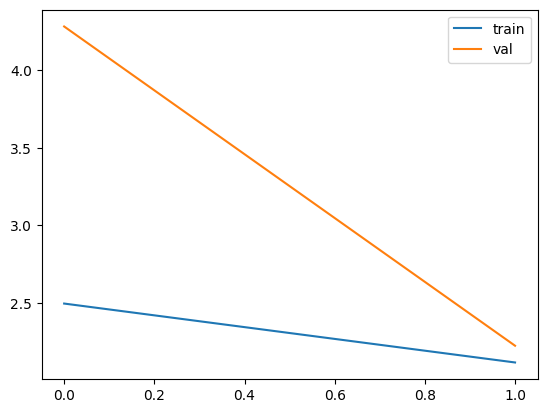

In [6]:
os.makedirs("weights", exist_ok=True)
train_main(dtrain, dval, vocab_size, params)

In [22]:
!zip -r /content/weights.zip /content/weights # run this on collab to zip up the weights folder for download

updating: content/weights/ (stored 0%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_320.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_360.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_310.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_160.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_0.pt (deflated 12%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_110.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_460.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_440.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_550.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_380.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_200.pt (deflated 10%)
updating: content/weights/transformer_e64_cs16_nl4_nh4_90.pt (deflated 10%)
updating: content/weights/transformer_e6

# Generated output

In [10]:
esize = 64
cs = 16
nl = 4
nh = 4
epoch = 600
width = esize * 4 # Define width here
pos_enc = True # Changed from True to False to match trained model
name = model_name(esize, cs, nl, nh, epoch, pos_enc)
model = Transformer(vocab_size, embed_size=esize, num_layers=nl, nhead=nh, layer_width=width,
                    max_len=1024+32, N=512.0, pos_enc=pos_enc)
mask = torch.nn.Transformer.generate_square_subsequent_mask(cs)
model.load_state_dict(torch.load(f"weights/{name}", weights_only=True, map_location='cuda'))

<All keys matched successfully>

### Prompt Choices
Find prompts for which both models (with and without positional encoding) work well and do not work well. Discuss why you think the models perform well or poorly for these prompts.

In [11]:
# prompt where the model with positional encoding works well
prompt = "What men of name are slain on either side?"  # TODO: place your prompt to start the text generation here
text = generate_text(model, prompt, 500, cs, encode, decode)  # TODO uncomment this line to generate text
print(text)

What men of name are slain on either side?

JULIET:
Until the hazard: which is this love's hands
As I lose that; then wonders our garet?

MARCIUS:
No, I am Lord Marshal:
Poor prince be thy true hearts frank may brow meet Romeo he in what
I am dutuous man the resteed!
Ah, to answer, are in one were letters make me news; and there, or I see your city would kend not the general further's particula's prayer my noble dukes?

LA:
The first spring to take it,
And shall not an attendary
heart your honour,
That habit I'll swear next we how that 


In [13]:
# prompt where the model with positional encoding does not work well
prompt = "Here is how to cook a steak. Step One, preheat the grill."  # TODO: place your prompt to start the text generation here
text = generate_text(model, prompt, 500, cs, encode, decode)  # TODO uncomment this line to generate text
print(text)

Here is how to cook a steak. Step One, preheat the grill.

HENRY BOLINGBROKE:
I am ench, good mother;
But where he has a noble
With kings, masters the business
That effects of his own stirs.

MENENIUS:
Worthy he shall wing's hate?
Then he is Lements
To lurks in the head:
As the northern?

WARWICK:
How many daughtered will who thumb thee now fords with a king:
Most dear true at old son
Which you know I may break him with a troth he would ladies be vows,
Prevaid, to be were this tongue.

GLOUMNIA:
He is triight is Tybalt, sir, hath be that you do: must,


In [14]:
# load model without positional encoding
pos_enc = False
name = model_name(esize, cs, nl, nh, epoch, pos_enc)
model = Transformer(vocab_size, embed_size=esize, num_layers=nl, nhead=nh, layer_width=width,
                    max_len=1024+32, N=512.0, pos_enc=pos_enc)
mask = torch.nn.Transformer.generate_square_subsequent_mask(cs)
model.load_state_dict(torch.load(f"weights/{name}", weights_only=True, map_location='cuda'))

<All keys matched successfully>

In [15]:
# prompt where the model without positional encoding works well
prompt = "O, where is Romeo? Saw you him to-day?"  # TODO: place your prompt to start the text generation here
text = generate_text(model, prompt, 500, cs, encode, decode)  # TODO uncomment this line to generate text
print(text)

O, where is Romeo? Saw you him to-day?

COMINIUS:
Some incusivences be doubt to alone,
Lord-two trumpet; here's not to experious wears
A revoker of makes my tongue;
But by the be sue on the voices:
It is that he say had to dreams and sceent
That call thee this duke mark his body by some pass him day
to have been o' the haply wide thee will as the love try hearted thine more?

GREMIO:
I could have King Henry both accused comfort,
That received on my tied
Ay I passage you?

Clown:
I wish; I do, my brother;
In God's save I dry order le


In [17]:
# prompt where the model without positional encoding does not work well
prompt = "Here is how to fish. Step One, add the bait to the hook at the end of the fishing line."  # TODO: place your prompt to start the text generation here
text = generate_text(model, prompt, 500, cs, encode, decode)  # TODO uncomment this line to generate text
print(text)

Here is how to fish. Step One, add the bait to the hook at the end of the fishing line. Put it? were she worthy freshumes, been all thee cerne's resounds
Mails in my state,
You have done one.
Now, wife, my lord.

FRIAR LAURENCE:
I know my looks to him: whepherd mted may spark?

CLARENCE:
Speak they are the enough, let's must not, that, or Henry is a legs upon roarous Isabelance a Clarence you?

RIVERS:
I think you'll a kings, and my parting about blood.

ROMEO:
Out, good Caius Soldier:
Yea, 'tis the well demands
Master! cheerefore beauter than Parch's sway to--the county at way a 


## Response:
Why do you think each model performed well or poorly for these prompts?

Answer:

Each model performed well with its first prompts because they were direct quotes of the input text. Since these quotes are directly related to the Shakespearean training data, each model produced realistic looking output that seems to flow relatively well with the input. Each model performed poorly with its second prompts because they were not related to the input text at all. The input text has no mention of how to fish or cook a steak. Although the produced output still looked like a realistic copy of Shakespeare, it had nothing to do with the prompts because the text was not at all related to how-to questions.


# Investigating the Attention in Each Layer
After training the transformer model, you will investigate the attention weights in each layer of the transformer.

In [18]:
# helper functions for attention plotting and model selection

def plot_attention_weights(axs, weights, context):
    """
    Plot the self-attention weights over the context

    Parameters:
    axs: list of matplotlib.axes.Axes
        The axes to plot the attention weights on
    weights: torch.Tensor
        The attention weights for each head. Has shape: (num_heads, seq_len, seq_len)
    context: str
        The context used for the input
    """
    weights = weights.squeeze().cpu().numpy()
    for i in range(weights.shape[0]):
        w = weights[i].T
        w[w == 0] = np.nan
        axs[i].imshow(w, cmap='viridis', interpolation='nearest')
        axs[i].set_title(f'Head {i+1}')
        axs[i].set_xlabel('Input')
        axs[i].set_ylabel('Weights for Input')
        axs[i].set_xticks(range(len(context)))
        axs[i].set_yticks(range(len(context)))
        axs[i].set_xticklabels(list(context))
        axs[i].set_yticklabels(list(context))
        axs[i].set_aspect('auto')
        axs[i].grid(False)

def attention_main(model, prompt, encode, save_name, only_average=False):
    """
    Compute the attention weights for each head and averaged weights for each head and then plot them.
    Set only_average to True to only display the average weights.
    """

    model = model.to('cpu')
    model.eval()
    mask = torch.nn.Transformer.generate_square_subsequent_mask(len(prompt))
    with torch.no_grad():
        x = torch.tensor(encode(prompt), dtype=torch.long).reshape(-1, 1)
        if isinstance(model, Transformer):
            y_pred, att_weights = model(x, attn_mask=mask, return_att_weights=True)
        else:
            y_pred, att_weights = model(x, mask)
    nrows = int(np.round(att_weights[0].squeeze().shape[0]/2))
    for i, weights in enumerate(att_weights):  # plot the attention weights for each layer
        print(f'Plotting attention weights for layer {i}')
        fig, axs = plt.subplots(nrows,2, figsize=(8, 8))
        plot_attention_weights(axs.flat, weights, prompt)  # plot the attention weights for each head in the layer
        fig.subplots_adjust(left=0.1, right=0.97, top=0.95, bottom=0.1)
        fig.savefig(f'{save_name}_layer{i}.pdf')
        if only_average:
            plt.close()

    avg_weights = torch.stack([w.squeeze().mean(dim=0) for w in att_weights])  # average the attention weights over the heads
    nrows = int(np.round(avg_weights.shape[0]/2))
    fig, axs = plt.subplots(nrows,2, figsize=(8, 8))
    print('Plotting average attention weights for each layer')
    plot_attention_weights(axs.flat, avg_weights, prompt)  # plot the average attention weights for each layer
    for i in range(len(axs.flat)):
        axs.flat[i].set_title(f'Layer {i}')
    fig.subplots_adjust(left=0.1, right=0.97, top=0.95, bottom=0.1)
    fig.savefig(f'{save_name}_avg_weights.pdf')
    plt.show()

def find_best_model(dval, vocab_size, esize, cs, nl, nh, width, pos_enc, max_epochs=150):
    """
    Find the best model based on the validation loss. Searches over models saved every 10 epochs up to max_epochs.
    """
    vls = []
    vidx = []

    model = Transformer(vocab_size, embed_size=esize, num_layers=nl, nhead=nh, layer_width=width,
                        max_len=1024+32, N=512.0, pos_enc=pos_enc)
    mask = torch.nn.Transformer.generate_square_subsequent_mask(cs)
    for i in range(0, max_epochs+1, 10):
        name = model_name(esize, cs, nl, nh, i, pos_enc)
        model.load_state_dict(torch.load(f"weights/{name}", weights_only=True, map_location='cuda'))
        loss = val_loss(dval, model, nn.CrossEntropyLoss(), vocab_size, mask)
        vls.append(loss)
        vidx.append(i)
    plt.plot(vidx, vls)
    plt.savefig(f'val_loss_e{esize}_cs{cs}_nl{nl}_nh{nh}_pe{pos_enc}.png')
    epoch = vidx[np.argmin(vls)]

    model_path = f"weights/{model_name(esize, cs, nl, nh, epoch, pos_enc)}"
    model.load_state_dict(torch.load(model_path, weights_only=True, map_location='cuda'))
    return model, epoch

def plot_attention(prompt, dval, vocab_size, esize, cs, nl, nh, width, encode, max_epochs=150, use_big_model=False, average_only=False):
    """
    Plot the attention weights for the model

    Set use_big_model to True to use the big model. This will load the model from the file model_posenc_True.pth or model_posenc_False.pth
    Set use_big_model to False to use the best model found during training. This will load the model from the file attention_esize_cs_nl_nh_epoch.pth
    """

    for pos_enc in [True, False]:  # check attention for models with and without positional encoding
        print("Positional Encoding:", pos_enc)
        if use_big_model:
            model = torch.jit.load(f"model_posenc_{pos_enc}.pth")
            save_name = f"attention_big_{pos_enc}"
        else:
            # find the best model
            model, epoch = find_best_model(dval, vocab_size, esize, cs, nl, nh, width, pos_enc, max_epochs=max_epochs)
            save_name = f"attention_{esize}_{cs}_{nl}_{nh}_{epoch}"
            print("Best model found at epoch:", epoch)

        if pos_enc == False:
            save_name += "_nope"
        attention_main(model, prompt, encode, save_name, only_average=average_only)

In [19]:
# prep the eval data to select best saved model
even_eval = len(dval)//(cs+1)
dval = dval[:even_eval*(cs+1)].reshape(-1, cs+1).T

In [20]:
# best hyperparameters found
esize = 64
cs = 16
nl = 4
nh = 4
width = esize*4
max_epoch = 600

Positional Encoding: True
Best model found at epoch: 150
Plotting attention weights for layer 0
Plotting attention weights for layer 1
Plotting attention weights for layer 2
Plotting attention weights for layer 3
Plotting average attention weights for each layer


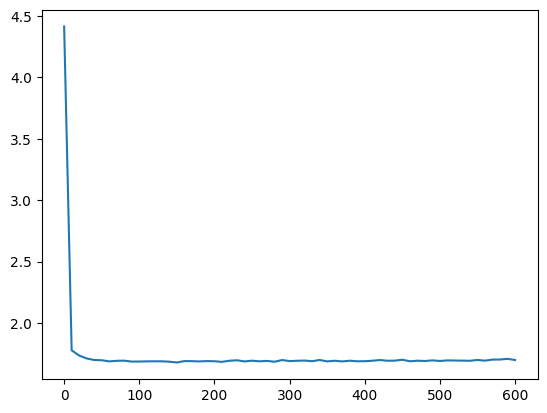

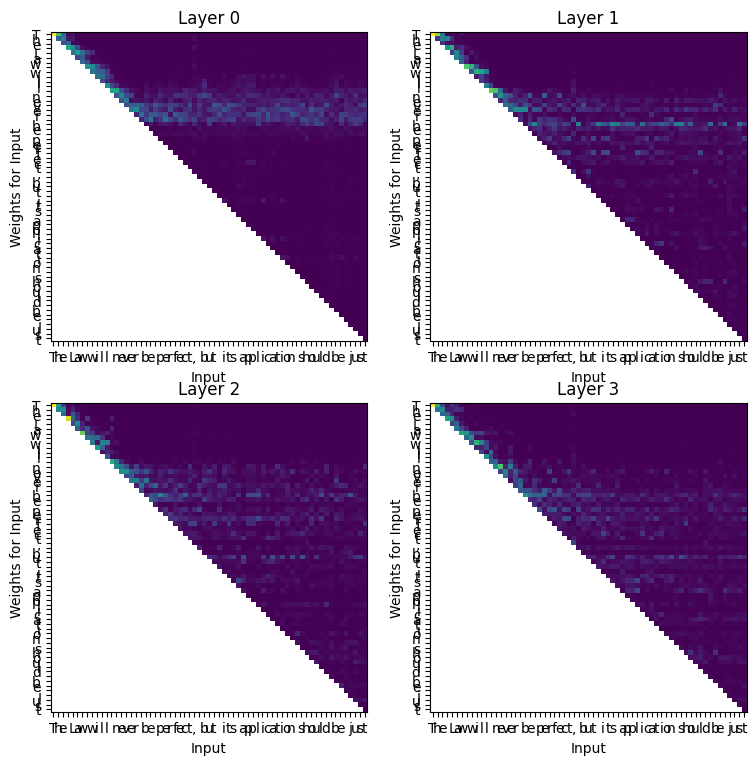

Positional Encoding: False
Best model found at epoch: 370
Plotting attention weights for layer 0
Plotting attention weights for layer 1
Plotting attention weights for layer 2
Plotting attention weights for layer 3
Plotting average attention weights for each layer


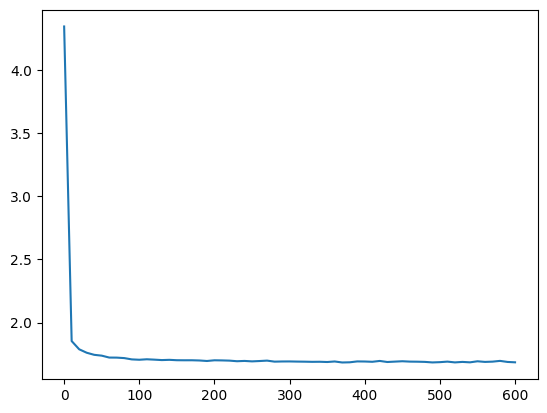

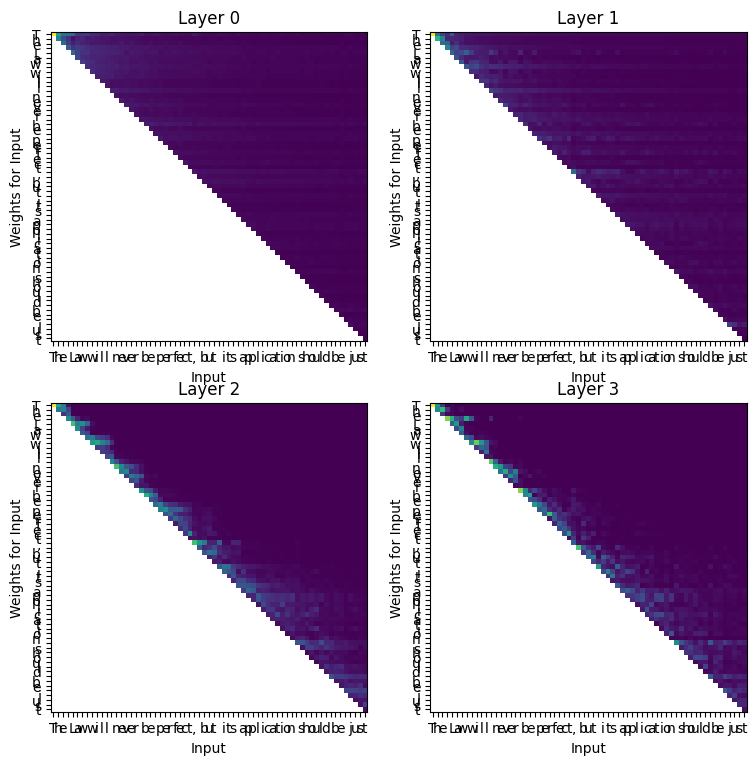

In [23]:
# train a model with and without positional encoding then run this code.
prompt = "The Law will never be perfect, but its application should be just"  # prompt to examine the attention weights. TODO Find prompts to illustrate different properties to answer the questions below.
use_big_model = False  # set to True to use the big model that was provided. This will load the model from the file model_posenc_True.pth or model_posenc_False.pth
average_only = True  # set to True to only show the average attention weights across heads.
plot_attention(prompt, dval, vocab_size, esize, cs, nl, nh, width, encode, max_epochs=max_epoch, use_big_model=use_big_model, average_only=average_only)

## Questions
Answer the following questions based on your observations of the attention weights in each layer.

**Q1** : What trends do you notice in the attention weights? Do earlier layers attend to different parts of the input than later layers? Are there any intuitive patterns in the attention weights? Give specific examples from your plots to support your observations.

Answer:
For each layer, the first layer's weights were noticeably lighter towards the front end of each character's weights. This trend became more prominent for each successive layer. For instance, the lighter weights for the first layer of the model were concentrated around characters in the subsequence "The Law will never be", but in successive layers later characters experienced a decrease in front end weights as well. However, the weights for the "The Law will never be" subseqence characters remained the lightest in each layer. This aligns with my expectation of self-attention recognizing key details in the middle parts of each subsequence contributing more to the structure of other sequences throughout the input text.

**Q2** : Discuss the differences you observe in the attention weights between the model with positional encoding and the model without positional encoding.
Reference specifics in the figures.

Answer:

The model with positional encoding had noticeably lighter weights for each character around the middle of the sentence in each layer, while the model without positional encoding did not. For the model with positional encoding, the weights associated with each character in the subsequence "will never be" were noticeably lighter in each layer in contrast to the layer weights for the same subsequence for the model without positional encoding. This matches with my expectation of the model with positional encoding valuing characters towards the beginning and end of the sentence more in contrast to the other model that just relied on self attention.